# 10/15/24: recognition phase plots
* As a reminder, 16 subjs across 29 session undergo 40-trial recognition phases, with 20 familiar & 20 novel images.  
* Subjs rate images from 1 (familiar, sure) to 6 (novel, sure).  

After wrangling all their data into 1 df, I plotted:  
1. Distribution of RTs  .
2. Rasters & PSTHs for example cells from each region. For the latter, I trimmed all trials to 5s.  
3. Distribution of avg FRs across trials (non-zero FRs only).  
4. Trial-avged FR for correct vs incorrect (note that these are imbalanced classes as printed above the plot).  
5. Trial-avged FR for (correct+high confidence) vs others (much better balanced).  


In [47]:
import warnings
warnings.filterwarnings("ignore")

import os, pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy.stats as stats, glob
from pynwb import NWBHDF5IO
from pathlib import Path
from convnwb.io import load_nwbfile

## check data

In [50]:
norm_choice = 'min'
# norm_choice = 'trial'

df = pd.read_pickle(f'./data_files/neuron_by_trial_norm_by_{norm_choice}.pkl')

# ensure no missing data
# note that there is 1 session with 48 neurons that has only 34 trials
# total neurons = 1409+48 = 1457
print(len(df) == (1409*42 + 48*36)) # 36 and not 34 because encoding+baseline are being counted

df_recognition = df[df['stim_phase'] == 'recognition']
print(f'len_df = {len(df)}, len_recog = {len(df_recognition)}')
# ensure correct number of rows were dropped
print(len(df)-(2*1457) == len(df_recognition))

num_subjs = len(np.unique(df_recognition['subj']))
num_sessions = len(np.unique(df_recognition['sess']))
num_neurons = len(np.unique(df_recognition['neuron']))
print(f'{num_subjs} subjects, {num_sessions} sessions, {num_neurons} neurons')

# df_recognition = df_recognition[df_recognition['FR'] != 0]
df_recognition.head()

True
len_df = 60906, len_recog = 57992
True
16 subjects, 29 sessions, 1457 neurons


,subj,sess,neuron,region,start_time,stop_time,RT,trial_spikes,trial_aligned_spikes,num_spikes,FR,trial_smooth_spikes,trial_smooth_FR,stim_phase,stimulus_file,response_correct,response_confidence,actual_response
2,P41,P41CS_R1,P41CS_R1_21_1_679_4,amygdala,566.346460,577.078362,10.731902,"[566.79785075, 568.845881, 569.40153725, 576.0...","[0.4513907499999732, 2.499420999999984, 3.0550...",4,0.372721,"[1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.040230,recognition,old015.png,1.0,2.0,5.0
3,P41,P41CS_R1,P41CS_R1_21_1_679_4,amygdala,578.122799,582.712578,4.589779,[582.05028225],[3.927483250000023],1,0.217875,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.011494,recognition,new021.png,1.0,3.0,1.0
4,P41,P41CS_R1,P41CS_R1_21_1_679_4,amygdala,583.755203,591.685106,7.929903,[589.2551855],[5.499982499999987],1,0.126105,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...",0.011494,recognition,new030.png,0.0,3.0,6.0
5,P41,P41CS_R1,P41CS_R1_21_1_679_4,amygdala,592.728012,597.998541,5.270529,"[593.583746, 593.7849335]","[0.855733999999984, 1.0569214999999303]",2,0.379469,"[1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.022989,recognition,old012.png,0.0,3.0,1.0
6,P41,P41CS_R1,P41CS_R1_21_1_679_4,amygdala,599.050103,603.022414,3.972311,"[599.334119, 600.3696805, 600.79902425, 602.03...","[0.2840159999999514, 1.319577499999923, 1.7489...",4,1.006971,"[1, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.040230,recognition,old021.png,1.0,3.0,6.0


## RT distribution & outlier sessions

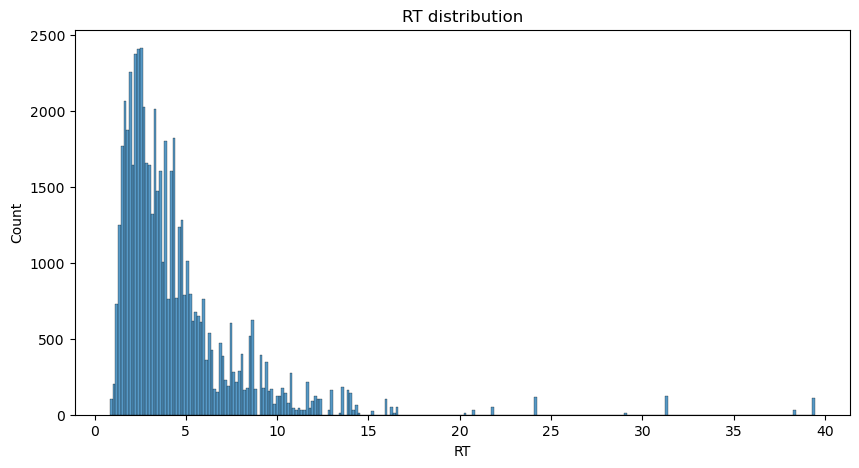

In [37]:
plt.figure(figsize=(10,5))
sns.histplot(df_recognition['RT'])
plt.title('RT distribution')
plt.show()

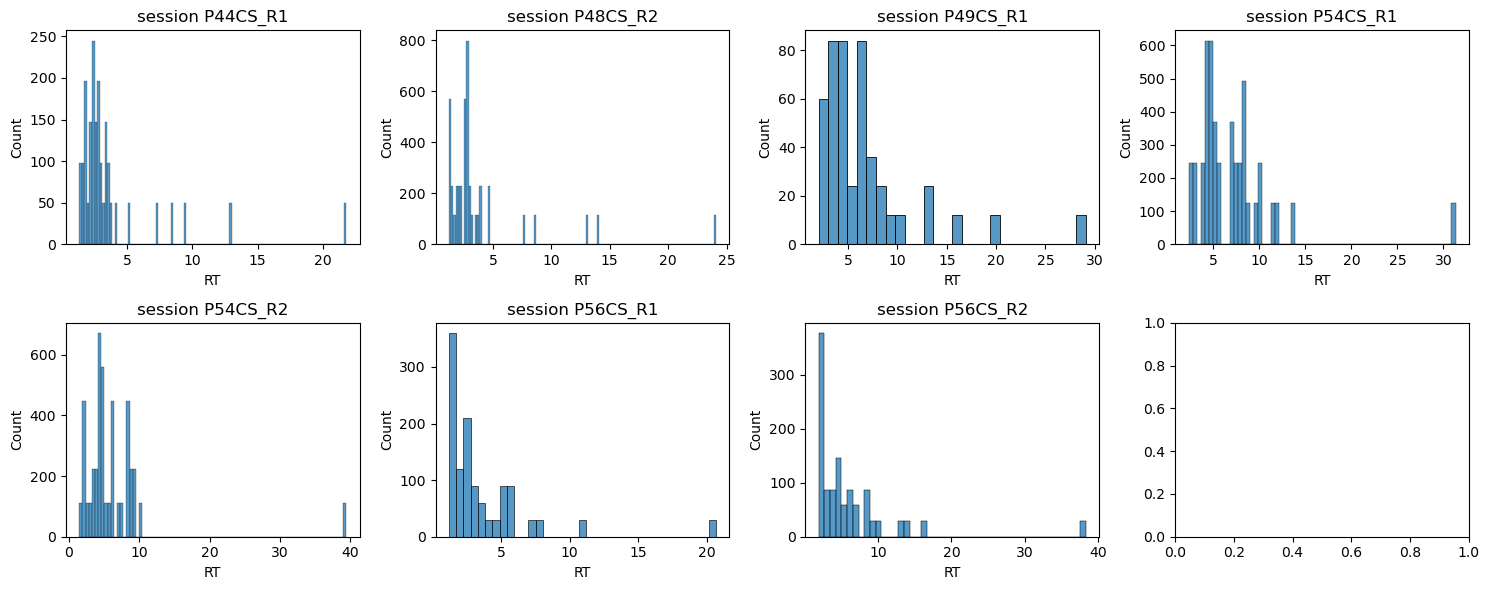

In [38]:
high_RT_df = df_recognition[df_recognition['RT'] > 20]
high_RT_sess_df = high_RT_df.groupby('sess').first().reset_index()
high_RT_sess = ['P44CS_R1', 'P48CS_R2', 'P49CS_R1', 'P54CS_R1', 'P54CS_R2', 'P56CS_R1', 'P56CS_R2']

fig, axs = plt.subplots(2, 4, figsize=(15,6))
axs, ax_count = axs.flatten(), 0

for sess_id, sess_df in df_recognition.groupby('sess'):
    
    if sess_id in high_RT_sess:

        sns.histplot(sess_df['RT'], ax=axs[ax_count])
        axs[ax_count].set_title(f'session {sess_id}')
        ax_count+=1

plt.tight_layout()
plt.show()


### example cell raster & PSTH by region

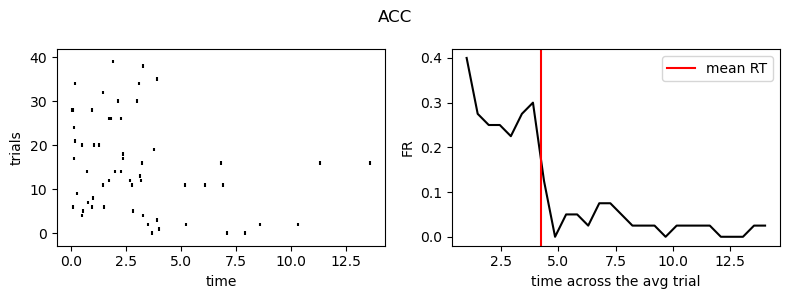

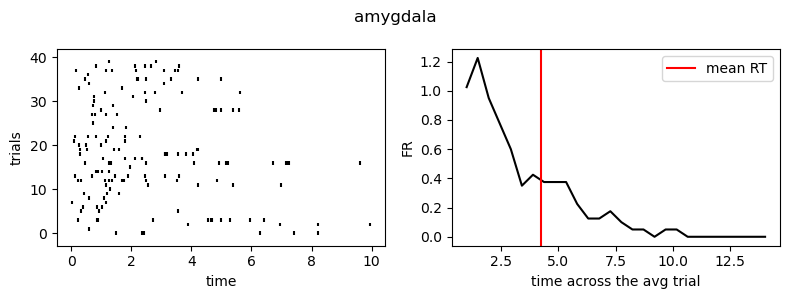

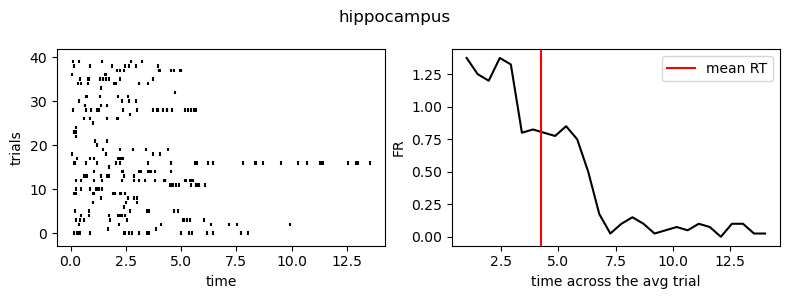

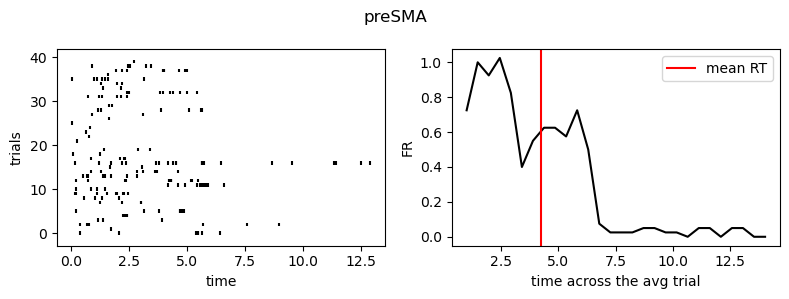

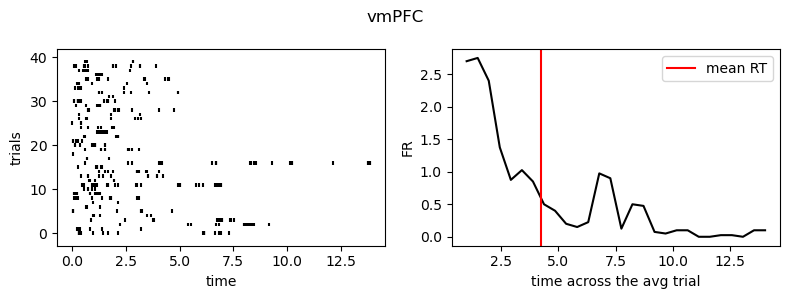

In [43]:
sess_num = 0

for session, session_df in df_recognition.groupby('sess'):

    # if this session does not have recordings from all 5 regions, continue to next session
    if not len(np.unique(session_df['region'])) == 5:
        continue
    
    sess_num += 1
    if sess_num < 1: # can be used to pick specific session
        continue

    for region, region_df in session_df.groupby('region'):

        neuron_num = 0

        fig, ax = plt.subplots(1, 2, figsize=(8, 3))
        fig.suptitle(region)

        for neuron, neuron_df in region_df.groupby('neuron'):
            
            neuron_num += 1
            if neuron_num < 1: # can be used to pick specific neuron
                continue
                
            # RASTER

            ax[0].eventplot(neuron_df['trial_aligned_spikes'], linelengths=0.8, color='black')
            ax[0].set_ylabel('trials')
            ax[0].set_xlabel('time')


            # SMOOTHED FR

            num_bins = len(neuron_df['trial_smooth_spikes'].iloc[0])
            x_time_points = np.linspace(1, np.max(neuron_df['RT']), num_bins)
            
            # convert df of lists to np array to be able to calculate mean
            trial_smooth_spikes_arr = np.array(neuron_df['trial_smooth_spikes'].tolist())
            
            ax[1].plot(x_time_points, np.mean(trial_smooth_spikes_arr, axis=0), color='black')
            ax[1].axvline(np.mean(neuron_df['RT']), color='red', label='mean RT')

            ax[1].set_ylabel('FR')
            ax[1].set_xlabel('time across the avg trial')

            break
        
        plt.legend()
        plt.tight_layout()
        plt.show()

    break


### discard outliers with extreme FRs

num_neurons * num_trials 48378
num_neurons * num_trials after outlier removal: 48378


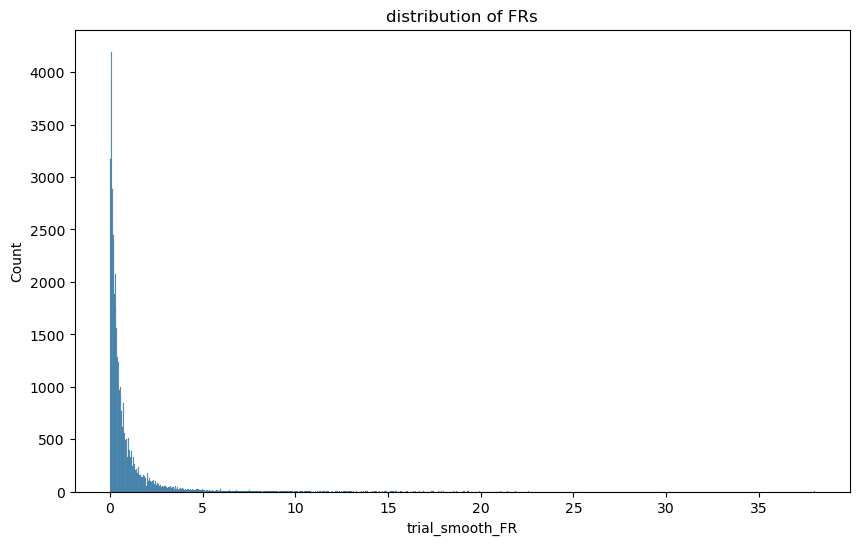

In [46]:
print(f'num_neurons * num_trials {len(df_recognition)}')

df_recognition = df_recognition[df_recognition['FR'] != 0]
print(f'num_neurons * num_trials after outlier removal: {len(df_recognition)}')

plt.figure(figsize=(10,6))
sns.histplot(df_recognition['trial_smooth_FR'])
plt.title('distribution of FRs')
plt.show()

### correct vs incorrect

response_correct
0.0    13814
1.0    44178
dtype: int64


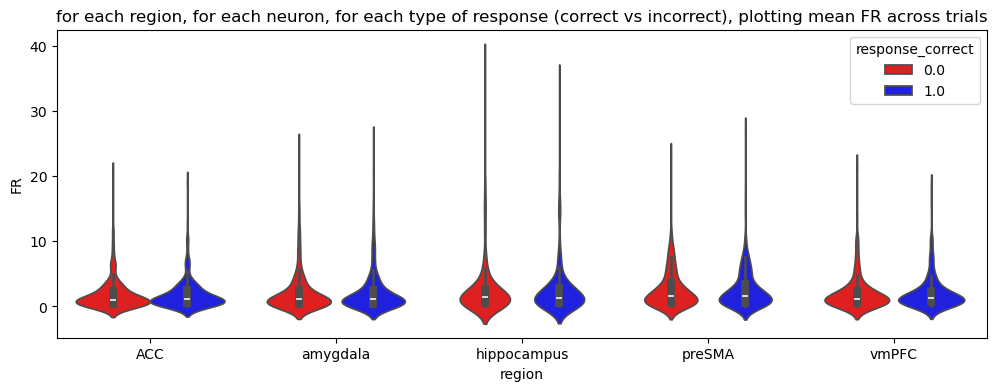

In [33]:
print(df_recognition.groupby(['response_correct']).size())

correctness_fr = df_recognition.groupby(['region', 'neuron', 'response_correct'])['FR'].mean().reset_index()
plt.figure(figsize=(12, 4))
sns.violinplot(correctness_fr, x='region', y='FR', hue='response_correct', palette=['red', 'blue'])
plt.title('for each region, for each neuron, for each type of response (correct vs incorrect), plotting mean FR across trials')
plt.show()


### (confident + correct) vs not

conf_corr
Confident & Correct    30404
Other                  27588
dtype: int64


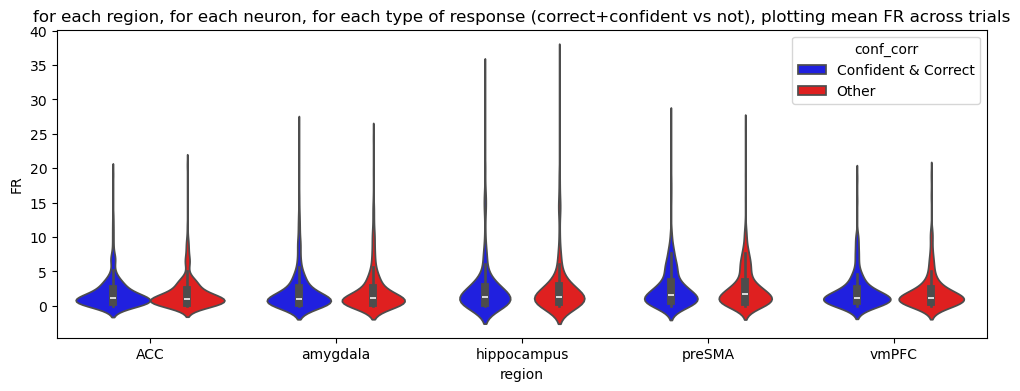

In [34]:
df_recognition['conf_corr'] = df_recognition.apply(lambda row: 'Confident & Correct' if row['response_confidence'] == 3 and row['response_correct'] == 1 else 'Other', axis=1)
print(df_recognition.groupby(['conf_corr']).size())

confidence_correctness_fr = df_recognition.groupby(['region', 'neuron', 'conf_corr'])['FR'].mean().reset_index()
plt.figure(figsize=(12, 4))
sns.violinplot(confidence_correctness_fr, x='region', y='FR', hue='conf_corr', palette=['blue', 'red'])
plt.title('for each region, for each neuron, for each type of response (correct+confident vs not), plotting mean FR across trials')
plt.show()
